In [2]:
# Importing libraries
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import random
from keras.api._v2.keras import layers, models
import keras.api._v2.keras as keras

# Turn on mixed-precision for speed-up
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Constants
BATCH_SIZE = 32
TRAIN_DATASET_PATH = "./res/training.csv"
TEST_DATASET_PATH = "./res/test.csv"

### Loading training and testing datasets

In [3]:
# Load dataset from CSV file
dataset_df = pd.read_csv(TRAIN_DATASET_PATH)

# Image landmarks to predict
USED_LANDMARKS = ['left_eye_center_x', 'left_eye_center_y',
                  'right_eye_center_x', 'right_eye_center_y',
                  'nose_tip_x', 'nose_tip_y',
                  'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y',
                  'Image']

# Drop rows with null values
dataset_df = dataset_df[USED_LANDMARKS].dropna()

# Construct feature array
X = np.array([np.stack((np.array([int(pixel) for pixel in image.split()]).reshape((96, 96)),)*3, axis=-1) for image in dataset_df['Image']])

# Construct target array
y = dataset_df[USED_LANDMARKS[:-1]].to_numpy()

# Train / Validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=2000, random_state=42)

# Load the testing images
test_dataset_df = pd.read_csv(TEST_DATASET_PATH)
X_test = np.array([np.stack((np.array([int(pixel) for pixel in image.split()]).reshape((96, 96)),)*3, axis=-1) for image in test_dataset_df['Image']])

# Build train dataset
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(buffer_size=len(X_train))
train_ds = train_ds.batch(BATCH_SIZE)

# Build train dataset
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = val_ds.batch(BATCH_SIZE)

2023-09-06 00:29:01.387173: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1105920000 exceeds 10% of free system memory.


### Model Training

In [16]:
# Model definition
model = models.Sequential(
    layers = [
        tf.keras.applications.EfficientNetV2S(
            include_top=False,
            weights="imagenet",
            input_shape=(96,96,3),
            include_preprocessing=True,
            pooling='max'
            ),
        
        layers.Dense(256, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(8),
        
        layers.Conv1DTranspose()
    ])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 1280)             20331360  
 l)                                                              
                                                                 
 dense_9 (Dense)             (None, 256)               327936    
                                                                 
 dense_10 (Dense)            (None, 64)                16448     
                                                                 
 dense_11 (Dense)            (None, 8)                 520       
                                                                 
Total params: 20,676,264
Trainable params: 20,522,392
Non-trainable params: 153,872
_________________________________________________________________


In [17]:
# Compiling model
model.compile(optimizer = keras.optimizers.Adam(learning_rate=1e-4),
              loss = tf.keras.losses.MeanAbsoluteError(),
              metrics = [r2_score],
              run_eagerly = True)

# Model training
history = model.fit(train_ds,
                    validation_data=(val_ds),
                    epochs=100,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_r2_score', mode='max', patience=2, restore_best_weights=True)])

Epoch 1/100


157/157 [==============================] - 237s 1s/step - loss: 15.4252 - r2_score: -55.3619 - val_loss: 3.1681 - val_r2_score: -0.2940
Epoch 2/100
157/157 [==============================] - 194s 1s/step - loss: 2.9673 - r2_score: -0.3122 - val_loss: 2.5165 - val_r2_score: 0.0979
Epoch 3/100
157/157 [==============================] - 194s 1s/step - loss: 2.5186 - r2_score: 0.0499 - val_loss: 2.3405 - val_r2_score: 0.2210
Epoch 4/100
157/157 [==============================] - 188s 1s/step - loss: 2.2462 - r2_score: 0.2222 - val_loss: 1.9792 - val_r2_score: 0.4185
Epoch 5/100
157/157 [==============================] - 187s 1s/step - loss: 2.0263 - r2_score: 0.3507 - val_loss: 1.9205 - val_r2_score: 0.4311
Epoch 6/100
157/157 [==============================] - 184s 1s/step - loss: 1.8847 - r2_score: 0.4318 - val_loss: 1.8816 - val_r2_score: 0.4848
Epoch 7/100
157/157 [==============================] - 178s 1s/step - loss: 1.7657 - r2_score: 0.5057 - val_loss: 1.7424 - val_r2_score: 0.5350

### Qualitative testing

56/56 [==============================] - 25s 396ms/step


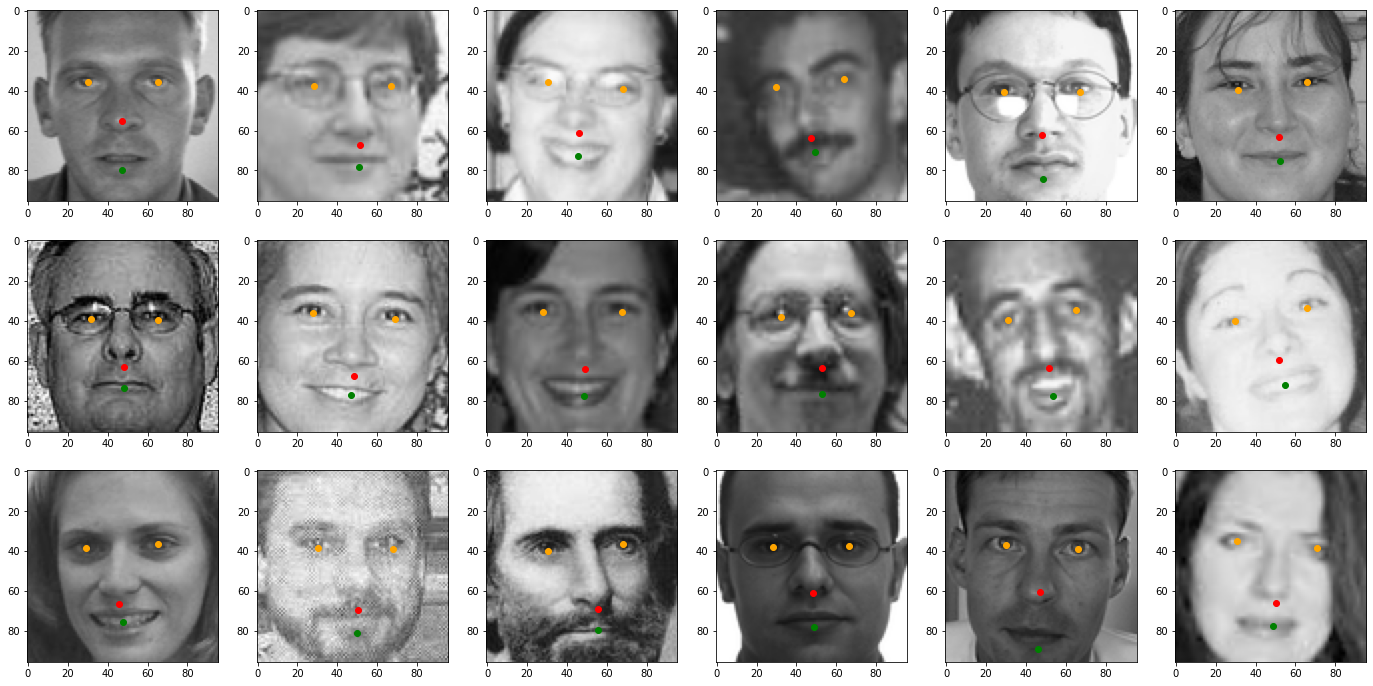

In [5]:
# Predict landmark locations in test data using model
predictions = model.predict(X_test)

# Setup 3x6 grid of subplots
f, axarr = plt.subplots(3,6)
f.set_size_inches(24, 12)

# Plot 18 random images and the predicted landmark locations
for idx, sample in enumerate(random.sample(range(0, X_test.shape[0]), 18)):
    axis = axarr.flatten()[idx]
    axis.imshow(X_test[sample], cmap='gray')
    axis.plot(predictions[sample][0], predictions[sample][1], 'o', color='orange')
    axis.plot(predictions[sample][2], predictions[sample][3], 'o', color='orange')
    axis.plot(predictions[sample][4], predictions[sample][5], 'o', color='red')
    axis.plot(predictions[sample][6], predictions[sample][7], 'o', color='green')

plt.show()